In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# dmu9 dataset downloaded from https://gdb.unibe.ch/downloads/
# read in all the smiles
smiles = open('data/1to6.dmu.smi', 'r').read().splitlines()
print(len(smiles))
print(max(len(w) for w in smiles))
print(smiles[:8])

35466
20
['C', 'N', 'O', 'C#C', 'C#N', 'N#N', 'C=C', 'C=N']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(smiles))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '#', 2: '(', 3: ')', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '=', 10: 'C', 11: 'N', 12: 'O', 0: '.'}
13


In [4]:
# shuffle the smiles
import random
random.seed(42)
random.shuffle(smiles)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(smiles):
    X, Y = [], []
    
    for s in smiles:
        context = [0] * block_size
        for ch in s + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
n1 = int(0.8 * len(smiles))
n2 = int(0.9 * len(smiles))
Xtr, Ytr = build_dataset(smiles[:n1])
Xdev, Ydev = build_dataset(smiles[n1:n2])
Xte, Yte = build_dataset(smiles[n2:])

torch.Size([310619, 8]) torch.Size([310619])
torch.Size([38929, 8]) torch.Size([38929])
torch.Size([38938, 8]) torch.Size([38938])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> O
.......O --> N
......ON --> 1
.....ON1 --> N
....ON1N --> =
...ON1N= --> C
..ON1N=C --> 1
.ON1N=C1 --> N
ON1N=C1N --> =
N1N=C1N= --> O
1N=C1N=O --> .
........ --> N
.......N --> =
......N= --> N
.....N=N --> C
....N=NC --> 1
...N=NC1 --> =
..N=NC1= --> N
.N=NC1=N --> N
N=NC1=NN --> 1


In [4]:
# Create MLP and WaveNet models
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

class makemoreMLP(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens):
        super().__init__()
        self.mlp_stack = nn.Sequential(nn.Embedding(vocab_size, embed_size),
                                       nn.Flatten(start_dim=1),
                                       nn.Linear(embed_size * block_size, num_hiddens, bias=False),
                                       nn.BatchNorm1d(num_hiddens),
                                       nn.Tanh(),
                                       nn.Linear(num_hiddens, vocab_size)
                                        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
n_embd = 10
n_hidden = 68
batch_size = 32

idx = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[idx], Ytr[idx]

model = makemoreMLP(vocab_size, n_embd, n_hidden)
x = model(Xb)
total_params = sum(p.numel() for p in model.parameters())
print(x.shape, total_params)

torch.Size([32, 13]) 6603


In [10]:
max_steps = 210000
ini_lr = 0.1
model = makemoreMLP(vocab_size, n_embd, n_hidden).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=ini_lr)

lossi = []

for i in range(max_steps):
    # Sample a batch of data
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx].to(device), Ytr[idx].to(device)
    
    # train the model
    model.train()
    optimizer.zero_grad()
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())
    # backprop
    loss.backward()
    optimizer.step()
    
    # Save checkpoint every 50,000 iterations
    modelName = 'MLP'
    if i % 50000 == 0 and i > 0:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'iteration': i
        }
        torch.save(checkpoint, f'models/{modelName}_checkpoint_{i}.pt')
        print(f'Checkpoint saved at iteration {i}')
    
    if i > 150000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01

      0/ 210000: 2.6824
  10000/ 210000: 1.2899
  20000/ 210000: 1.1549
  30000/ 210000: 1.2188
  40000/ 210000: 1.1414
  50000/ 210000: 1.0985
Checkpoint saved at iteration 50000
  60000/ 210000: 1.1983
  70000/ 210000: 0.8963
  80000/ 210000: 1.2821
  90000/ 210000: 1.1063
 100000/ 210000: 0.8807
Checkpoint saved at iteration 100000
 110000/ 210000: 0.9952
 120000/ 210000: 1.1066
 130000/ 210000: 0.8039
 140000/ 210000: 1.2632
 150000/ 210000: 0.9357
Checkpoint saved at iteration 150000
 160000/ 210000: 0.8697
 170000/ 210000: 0.9654
 180000/ 210000: 0.9753
 190000/ 210000: 0.8899
 200000/ 210000: 1.0367
Checkpoint saved at iteration 200000


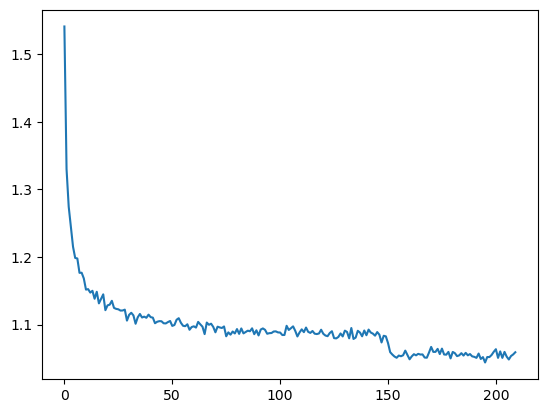

In [11]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [12]:
# Load the model from checkpoint
checkpoint = torch.load('models/MLP_checkpoint_200000.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model on train and dev sets
model.to('cpu')
model.eval()
total_params = sum(p.numel() for p in model.parameters())   
print(f'{total_params:,} total parameters.')
with torch.no_grad():
    logits = model(Xtr)
    loss = F.cross_entropy(logits, Ytr)
    print('train', loss.item())
    logits = model(Xdev)
    loss = F.cross_entropy(logits, Ydev)
    print('dev', loss.item())

6,603 total parameters.
train 1.0351909399032593
dev 1.04214346408844


In [5]:
# sample from the model
checkpoint = torch.load('models/MLP_checkpoint_200000.pt')
block_size = 8
vocab_size = 13
n_embd = 10
n_hidden = 68
batch_size = 32
model = makemoreMLP(vocab_size, n_embd, n_hidden)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
genList = []
with torch.no_grad():
    for _ in range(10000):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            # forward pass the neural net
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            # if we sample the special '.' token, break
            if ix == 0:
                break
        
        genList.append(''.join(itos[i] for i in out).replace('.','')) # decode and collect the generated smiles

In [6]:
genList

['C=C1N2CN12',
 'OC1(N)N2CN12',
 'NN=CONN',
 'N=C=C1CON1',
 'CCN=C=O',
 'N1OC11N2N=C2ON12',
 'C1N=CN2NN12',
 'C1=NC=NOO1',
 'NN(CO)C=N',
 'OC12OC1(O)N2OO12',
 'NNN1NNN1',
 'ONN1C#C1',
 'N1C2=C3C=C2C13',
 'NON1CNN1',
 'OCN1N=C=N1',
 'CN(C=O)=NC',
 'N=COC=O',
 'NC(O)C1ON1',
 'CN1C=C2OC12',
 'C#CNC1=CN1O',
 'OCC1=C=CN1',
 'OONC1=NO1',
 'O1ON=NC#C1',
 'C1OC2(O1)C=C2',
 'OC=C=NC=N',
 'NCN=COO',
 'OC1=NN2CN12',
 'COC(O)=N',
 'N=C=C=C1',
 'N1N=C2CC1=N2',
 'NCN=C(O)OO',
 'CN1C=NC1=O',
 'OC1CN=CN1',
 'C1NC2NN12',
 'CC(=N)N(N)O',
 'COOC1C=O1',
 'OC(=O)NN=N',
 'C=CC12C3CC123',
 'CON(O)CO',
 'N=COC1CO1',
 'CN1C23C4ON2N13',
 'OC1=NC(=C)C#C',
 'CC(C=C)C=C',
 'CC1NN=C1',
 'ON1COC#N1',
 'NC1CC#NC1',
 'CC1OC2=C1N2',
 'NC1(N)C#N1',
 'NC1=C(O)C1',
 'C=CC=C1C=N1',
 'NCCOCN',
 'C1N=C2N3C1C23',
 'CC=C(N)C#C1',
 'N1OC#CC1',
 'NN=C=CCN',
 'COC(O)=C=N1',
 'O=C=C1CNO1',
 'ONN=NN=N',
 'NC1=CNOO1',
 'C1NN2NC12',
 'C=C1CC2N=C12',
 'CC1=C2NN1N2',
 'CN=CON=N',
 'ON1C2NC12',
 'CN1NN2C=CC12',
 'NOC1=C2OC12',
 'CC1=C2N

In [7]:
# Check for validity
from rdkit import Chem
# Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

validCount = 0
uniqueList = []
for s in genList:
    if Chem.MolFromSmiles(s):
        validCount += 1
        canonicalSmiles = Chem.MolToSmiles(Chem.MolFromSmiles(s))
        if canonicalSmiles not in uniqueList:
            uniqueList.append(canonicalSmiles) 
print(f"Valid SMILES: {validCount}/{len(genList)}")
print(f"Unique SMILES: {len(uniqueList)}/{validCount}")

Valid SMILES: 8652/10000
Unique SMILES: 7299/8652


In [8]:
import rdkit
print(rdkit.__version__)

2024.03.3


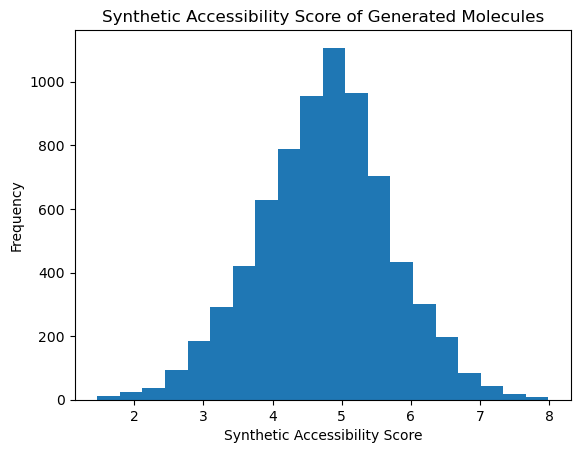

In [9]:
# Compute synthetic accessibility score 
import sys, os
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from SA_Score.sascorer import calculateScore
sasList = [calculateScore(Chem.MolFromSmiles(s)) for s in uniqueList]
plt.hist(sasList, bins=20)
plt.xlabel('Synthetic Accessibility Score')
plt.ylabel('Frequency')
plt.title('Synthetic Accessibility Score of Generated Molecules')
plt.show()

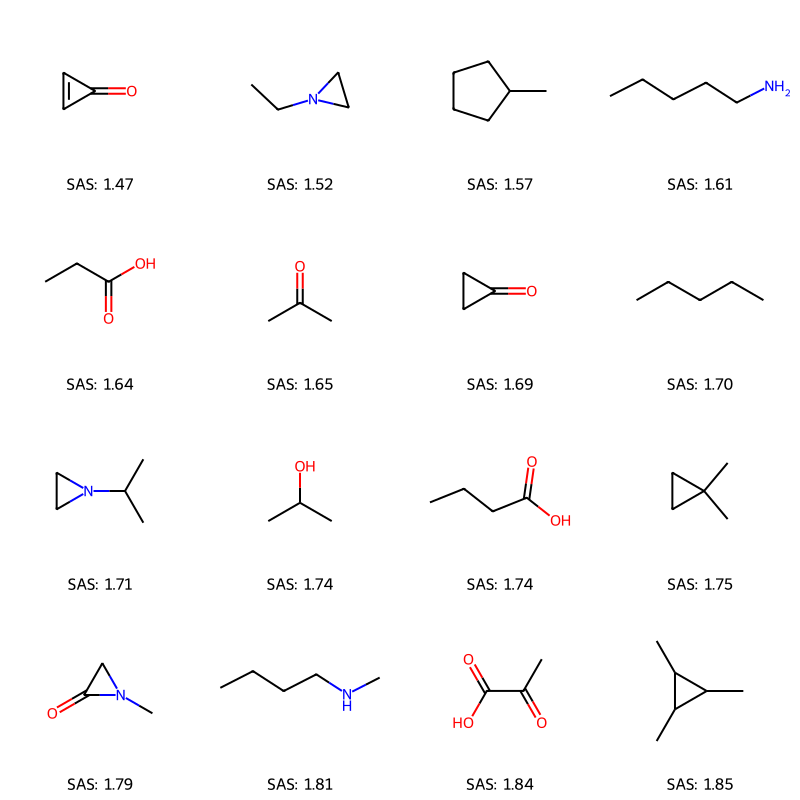

In [10]:
# Sort the generated molecules by synthetic accessibility score
from rdkit.Chem import Draw
sortedList = [s for _,s in sorted(zip(sasList,uniqueList), reverse=False)]
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[:16]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[:16]])

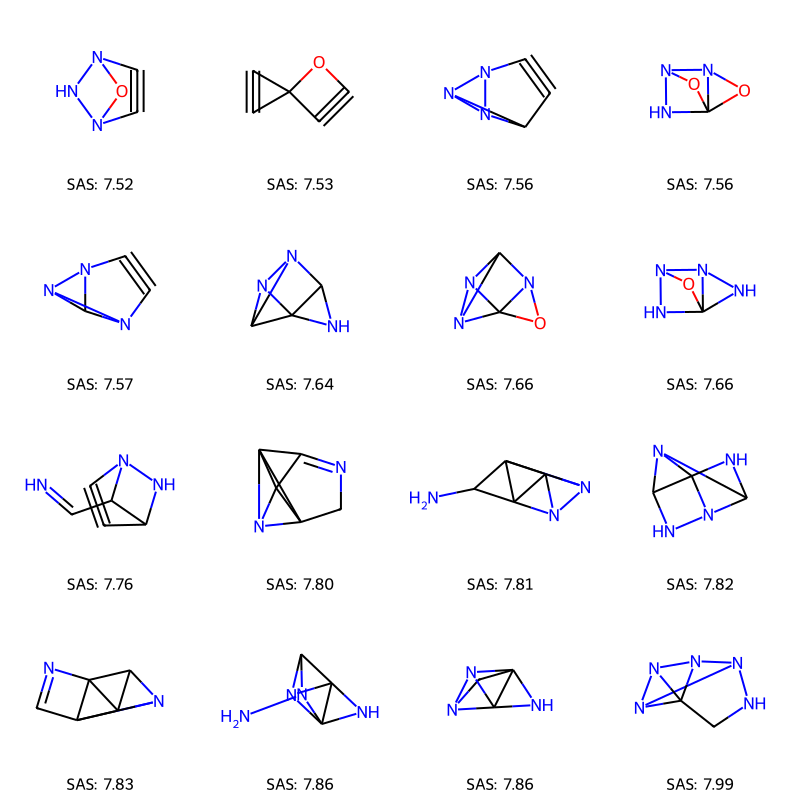

In [11]:
# Draw the molecules with the highest synthetic accessibility score
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[-16:]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[-16:]])